# Simple ConvNet model in tensorflow
Construction of a simple convolutional network with Tensorflow to demonstrate the basic functions of the framework.
The MNIST dataset is used for network testing.

In [15]:
from __future__ import print_function

from tensorflow.examples.tutorials.mnist import input_data
from scipy import misc
import tensorflow as tf
import numpy as np
import time

Load MNIST data

In [ ]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

In [6]:
X_train = mnist.train.images
Y_train = mnist.train.labels
X_valid = mnist.validation.images
Y_valid = mnist.validation.labels

print('=====Training set=====')
print('images:', X_train.shape)
print('labels:', Y_train.shape)
print('\n=====Validation set=====')
print('images:', X_valid.shape)
print('labels:', Y_valid.shape)

=====Training set=====
images: (55000, 784)
labels: (55000, 10)

=====Validation set=====
images: (5000, 784)
labels: (5000, 10)


We are using a convolutional network, so it is more convenient to leave the images in their original format, in the case of MNIST, 28x28.

In [62]:
image_size = 28
num_channels = 1

def reformat(data):
    return np.reshape(data, (-1, image_size, image_size, num_channels))

X_train = reformat(train_dataset)
X_valid = reformat(valid_dataset)

print('=====Training set=====')
print('images:', X_train.shape)
print('labels:', Y_train.shape)
print('\n=====Validation set=====')
print('images:', X_valid.shape)
print('labels:', Y_valid.shape)

=====Training set=====
images: (55000, 28, 28, 1)
labels: (55000, 10)

=====Validation set=====
images: (5000, 28, 28, 1)
labels: (5000, 10)


(Optional) Display some MNIST images. Run multiple times for different results

52191


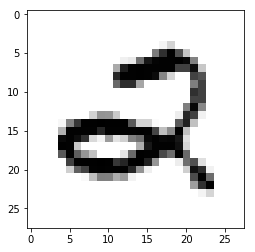

In [86]:
import matplotlib.pyplot as plt
from random import randint
index = randint(0, X_train.shape[0] - 1)
print(index)
plt.imshow(X_train[index].reshape(28, 28), cmap='gray_r')
plt.show()

Build the computational graph

In [84]:
batch_size = 100
filter_size = 5
depth1 = 6
depth2 = 16
fc_input_size = 400 # tentar calcular com o shape quando tiver tempo
fc1_size = 120
fc2_size = 84
num_labels = 10

graph = tf.Graph()

with graph.as_default():
    
    # inputs
    data = tf.placeholder(tf.float32, shape=(None, image_size, image_size, num_channels))
    labels = tf.placeholder(tf.float32, shape=(None, num_labels))
    
    # convolutional layers learnable parameters
    layer1_weights = tf.Variable(tf.truncated_normal([filter_size, filter_size, num_channels, depth1], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth1]))
    
    layer2_weights = tf.Variable(tf.truncated_normal([filter_size, filter_size, depth1, depth2], stddev=0.1))
    layer2_biases = tf.Variable(tf.zeros([depth2]))
    
    # feedforward layers learnable parameters
    layer3_weights = tf.Variable(tf.truncated_normal([fc_input_size, fc1_size], stddev=0.1))
    layer3_biases = tf.Variable(tf.zeros([fc1_size]))
    
    layer4_weights = tf.Variable(tf.truncated_normal([fc1_size, fc2_size], stddev=0.1))
    layer4_biases = tf.Variable(tf.zeros([fc2_size]))
    
    layer5_weights = tf.Variable(tf.truncated_normal([fc2_size, num_labels], stddev=0.1))
    layer5_biases = tf.Variable(tf.zeros([num_labels]))
    
    # build the model
    def model(data):
        conv1 = tf.nn.relu(tf.add(tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME'), layer1_biases))
        pool1 = tf.nn.max_pool(conv1, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
        
        conv2 = tf.nn.relu(tf.add(tf.nn.conv2d(pool1, layer2_weights, [1, 1, 1, 1], padding='VALID'), layer2_biases))
        pool2 = tf.nn.max_pool(conv2, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
        
        shape = pool2.get_shape().as_list()
        reshaped = tf.reshape(pool2, [-1, 400])
        fc1 = tf.nn.relu(tf.add(tf.matmul(reshaped, layer3_weights), layer3_biases))
        
        fc2 = tf.nn.relu(tf.add(tf.matmul(fc1, layer4_weights), layer4_biases))
        
        return tf.add(tf.matmul(fc2, layer5_weights), layer5_biases)
    
    
    # optimizing
    logits = model(data)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
    optmizer = tf.train.AdamOptimizer(0.001).minimize(loss)
    
    # prediction and accuracy
    prediction = tf.nn.softmax(logits)
    correct_prediction = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
    model_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Run the model

In [85]:
num_epochs = 20 # if taking too long to run, changing this to 10 should make little to no difference
num_batches = int(mnist.train.num_examples/batch_size)

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    
    for epoch in range(num_epochs):
        print('epoch', epoch + 1)
        start_time = time.time()
        for batch in range(num_batches):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            batch_x = reformat(batch_x)
            x_valid = reformat(mnist.validation.images)
            y_valid = mnist.validation.labels
            _, l = session.run([optmizer, loss], feed_dict={data:batch_x, labels:batch_y})
#             l = session.run(loss, feed_dict={data:batch_x, labels:batch_y})
            valid_acc = session.run(model_accuracy, feed_dict={data:x_valid, labels:y_valid})
        print('loss:', l)
        print('validation accuracy:', valid_acc)
        print('--- %s minutes ---' % ((time.time() - start_time)/60))
        print()
    
    test_data = reformat(mnist.test.images)
    test_acc = session.run(model_accuracy, feed_dict={data:test_data, labels:mnist.test.labels})
    print('test accuracy:', test_acc)
    print('--- %s minutes ---' % ((time.time() - start_time)/60))

epoch 1
loss: 0.103588
validation accuracy: 0.9642
--- 0.295673596859 minutes ---

epoch 2
loss: 0.0538965
validation accuracy: 0.9816
--- 0.294170868397 minutes ---

epoch 3
loss: 0.0721029
validation accuracy: 0.9824
--- 0.289755634467 minutes ---

epoch 4
loss: 0.0239399
validation accuracy: 0.9836
--- 0.298274699847 minutes ---

epoch 5
loss: 0.010534
validation accuracy: 0.9872
--- 0.295529699326 minutes ---

epoch 6
loss: 0.0214702
validation accuracy: 0.9874
--- 0.292865184943 minutes ---

epoch 7
loss: 0.0293376
validation accuracy: 0.9886
--- 0.293183398247 minutes ---

epoch 8
loss: 0.0651265
validation accuracy: 0.9848
--- 0.294742063681 minutes ---

epoch 9
loss: 0.0224603
validation accuracy: 0.99
--- 0.290889648596 minutes ---

epoch 10
loss: 0.0161203
validation accuracy: 0.98
--- 0.294297949473 minutes ---

epoch 11
loss: 0.00339015
validation accuracy: 0.9878
--- 0.296473983924 minutes ---

epoch 12
loss: 0.00108593
validation accuracy: 0.9894
--- 0.291473066807 minute